# M44

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from scipy.optimize import curve_fit

import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 8]

### Define functions

In [195]:
def gminusv(gbp_grp):
    """Given G_BP - G_RP, get G_V.
    From Johnson-Cousins Relationship
    """
    b = -0.01760
    m1 = -0.006860
    m2 = -0.1732
    g_v = m2*(gbp_grp)**2 + m1*(gbp_grp) + b
    return g_v

def gminusI(gbp_grp):
    """Given G_BP - G_RP, get G_I.
    From Johnson-Cousins Relationship
    """
    b = 0.02085
    m1 = 0.7419
    m2 = -0.09631
    g_I = m2*(gbp_grp)**2 + m1*(gbp_grp) + b
    return g_I

def cut_box(length, pmra, pmdec, bounds):
    
    """
    bounds = [ramin, ramax, decmin, decmax]
    
    Returns: None
    """
    for i in range(length):
        if pmra[i] < bounds[0] or pmra[i] > bounds[1] or pmdec[i] < bounds[2] or pmdec[i] > bounds[3]:
            pmra[i] = np.nan
            pmdec[i] = np.nan
            
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))


def fit_gauss(x, p0, RA=True, Dec=False, nplot='3'):
    
    bin_heights, bin_borders, _ = plt.hist(x, bins='auto', label='histogram', color='darkorchid');
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=p0)

    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
    plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit', c='deeppink')
    plt.legend()

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    if RA==True:
        plt.xlabel('RA Proper Motions (deg)', fontsize=25)
        plt.title('M44 RA Proper Motions (No Cluster Vetting)', fontsize=25)
        plt.savefig('M44/Plot3_M44_RAProperMotions.png', dpi=150)
        
    elif Dec==True:
        plt.xlabel('Dec Proper Motions (deg)', fontsize=25)
        plt.title('M44 Dec Proper Motions (No Cluster Vetting)', fontsize=25)
        plt.savefig('M44/Plot3_M44_DecProperMotions.png', dpi=150)


    
    return popt


def isInside(circle_x, circle_y, rad, x, y):
        
    """Is x, y inside circle?
    """
    if ((x - circle_x) * (x - circle_x) + 
        (y - circle_y) * (y - circle_y) <= rad * rad):
        return True
    else:
        return False

    
def EV_I(AV):
    """
    Given Av, get E(V-I).
    
    """
    
    return AV/2.5

def V_I0(AV, V_I):
    """
    Given Av and V-I, get (V-I) - E(V-I).
    
    """
    
    return V_I-EV_I(AV)

def parallax_dist(mean_parallax):
    """
    Given parallax (arcsec), get distance (parsecs).
    
    """
    
    return 1./mean_parallax

def parallax_dist_errprop(parallax, parallax_err):
    """
    Given parallax error (arcsec), get distance error (parsecs).
    
    """
    return parallax_err/parallax
    

def dist_mag(dist, appmag, Av):
    """
    Distance modulus equation.
    Given distance, apparent mag, and Av, get absolute mag.
    
    """
    
    absmag = -1*(5*np.log10(dist)-5+Av-appmag)
    return absmag


def dist_mag_errprop(dist, delAv, deldist):
    """
    Distance modulus error propogation.
    Given distance, apparent mag, and Av, get absolute mag.
    
    """
    
    delA = 5*0.434*(deldist/dist)
    delM = np.sqrt(delAv**2 + delA**2)
    return delM

# Converting Gaia magnitude to V and I bands

In [230]:
# Read CSV of Gaia data
M44df = pd.read_csv('M44-result.csv')
M44df = M44df.dropna()


In [231]:
M44df

,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
0,661247117581081344,130.449701,19.544039,3.855002,0.781421,16.062482,1.331666,-32.161974,0.645550,20.065212,20.909658,18.649286
1,661252000959417728,130.306317,19.625577,0.916822,0.201574,0.207333,0.371091,-13.739286,0.204421,18.295052,19.105886,17.308954
2,661312233577516160,129.988270,19.857519,1.307611,1.014471,10.997225,1.704729,-7.076438,1.367781,20.040579,20.558813,18.657118
3,661254642361432960,130.431368,19.733011,-1.014703,0.567615,2.149774,0.918477,-7.873108,0.432088,19.499887,19.669580,18.870504
5,661302887731820800,130.295533,19.815007,0.510154,0.417109,7.204543,0.685978,3.813527,0.423623,19.402940,19.915648,18.219898
...,...,...,...,...,...,...,...,...,...,...,...,...
4325,664316232488735360,129.720806,19.815033,-0.245411,1.634785,-2.422676,2.430928,-2.646651,1.635340,20.681982,20.512768,19.417625
4326,664319432241543168,129.768493,19.922015,4.451520,0.285916,35.074011,0.422408,-37.965046,0.264301,18.049028,19.408169,16.817352
4327,664319226083107200,129.825345,19.946121,0.466222,0.068668,-0.002790,0.108675,-2.218892,0.069896,15.834229,16.089300,15.404865
4328,664319775838927488,129.740910,19.939999,-0.127218,0.104792,-0.706014,0.146085,-0.373231,0.080045,16.204430,16.667147,15.585865


In [199]:
pmra = np.array(M44df['pmra'])
pmdec = np.array(M44df['pmdec'])

pmra0 = np.array(M44df['pmra'])
pmdec0 = np.array(M44df['pmdec'])

ra0 = np.array(M44df['ra'])
dec0 = np.array(M44df['dec'])

In [200]:
# Get G_V and G_I for all stars in sample

g_v = gminusv(M44df['phot_bp_mean_mag']-M44df['phot_rp_mean_mag'])

g_I = gminusI(M44df['phot_bp_mean_mag']-M44df['phot_rp_mean_mag'])

In [201]:
# Get V mag and I mag for all stars in sample

V = -1*(g_v - M44df['phot_g_mean_mag'])
I = -1*(g_I - M44df['phot_g_mean_mag'])

# Get V-I mag for all stars in sample

V_I = V-I

# Step 4 - Color-Magnitude Diagram

Here, I plot a color-magnitude diagram based on the color (V-I) and V magnitude calculated above.

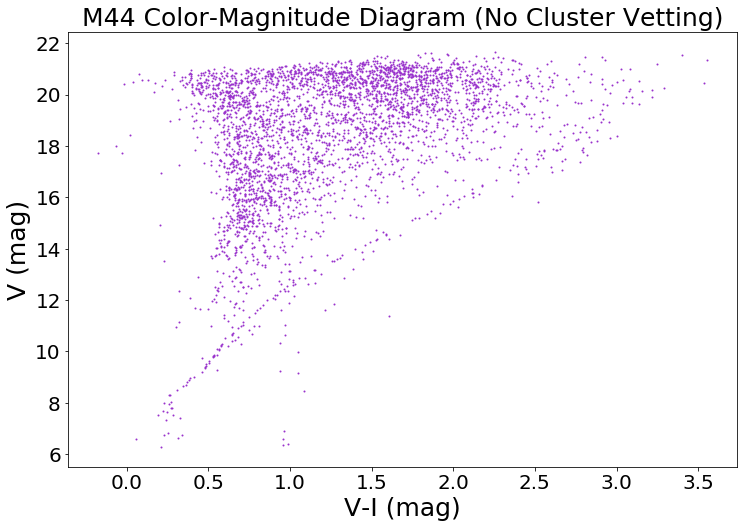

In [202]:
plt.scatter(V_I, V, s=1.0, c='darkorchid')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('V-I (mag)', fontsize=25)
plt.ylabel('V (mag)', fontsize=25)
plt.title('M44 Color-Magnitude Diagram (No Cluster Vetting)', fontsize=25)

plt.savefig('M44/M44_Plot1.png', dpi=150)

# Step 5: Proper Motions

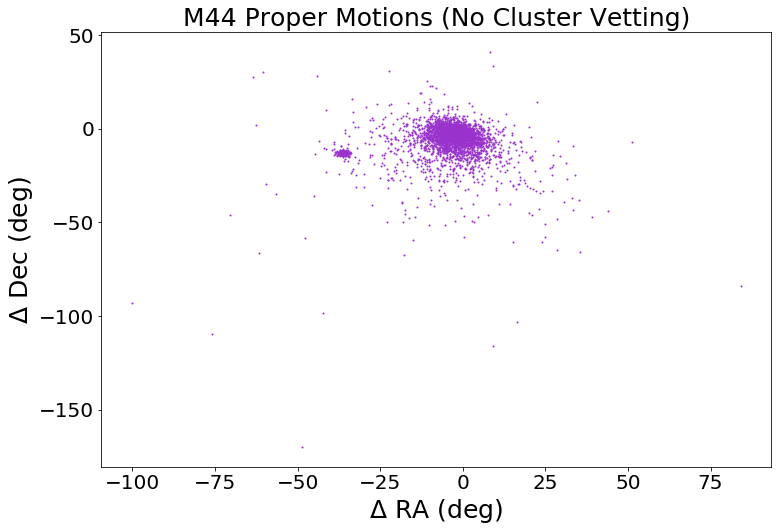

In [203]:
plt.scatter(pmra, pmdec, s=1.0, c='darkorchid')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$\Delta$ RA (deg)', fontsize=25)
plt.ylabel('$\Delta$ Dec (deg)', fontsize=25)
plt.title('M44 Proper Motions (No Cluster Vetting)', fontsize=25)

plt.savefig('M44/M44_Plot2.png', dpi=150)

# Step 6: Determine the Center

In [204]:
boxshape = [-100, -30, -100, 50]
cut_box(len(pmra), pmra, pmdec, boxshape)
        

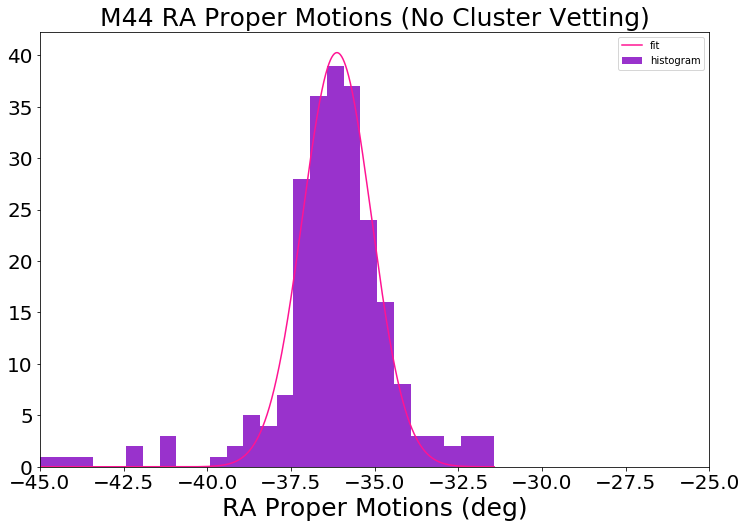

In [205]:
init_guess_a = [-36., 60., 5.]
plt.xlim(-45, -25)

ra_center, _, ra_sig = fit_gauss(pmra, init_guess_a)

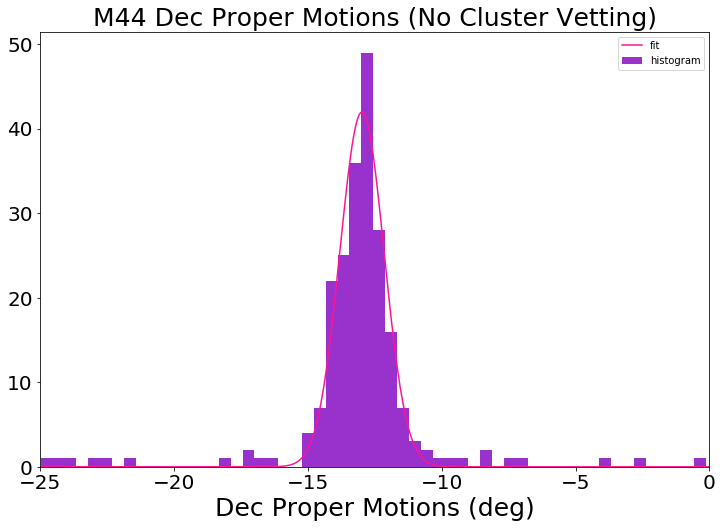

In [206]:
init_guess_b = [-15., 100., 5.]
plt.xlim(-25, 0)

dec_center, _, dec_sig = fit_gauss(pmdec, init_guess_b, RA=False, Dec=True)

In [207]:
# Convert parallax to arcseconds

M44df.insert(12, "parallax_arcsec", M44df['parallax']/1000., True)
M44df.insert(13, "parallax_err_arcsec", M44df['parallax_error']/1000., True)

M44df.insert(14, "distance_parsec", parallax_dist(M44df['parallax_arcsec']), True)
M44df.insert(15, "distance_err_parsec", parallax_dist_errprop(M44df['parallax_arcsec'], M44df['parallax_err_arcsec']))


M44df = M44df.drop(M44df[M44df.distance_parsec > 1800].index)

In [208]:
pmsig = np.mean((abs(ra_sig), abs(dec_sig)))

In [209]:
for index, row in M44df.iterrows():
    
    if not isInside(ra_center, dec_center, 3*pmsig , row['pmra'], row['pmdec']):
        M44df = M44df.drop(index)

In [210]:
pmra = np.array(M44df['pmra'])
pmdec = np.array(M44df['pmdec'])

g_v = gminusv(M44df['phot_bp_mean_mag']-M44df['phot_rp_mean_mag'])
g_I = gminusI(M44df['phot_bp_mean_mag']-M44df['phot_rp_mean_mag'])

V = -1*(g_v - M44df['phot_g_mean_mag'])
I = -1*(g_I - M44df['phot_g_mean_mag'])

V_I = V-I

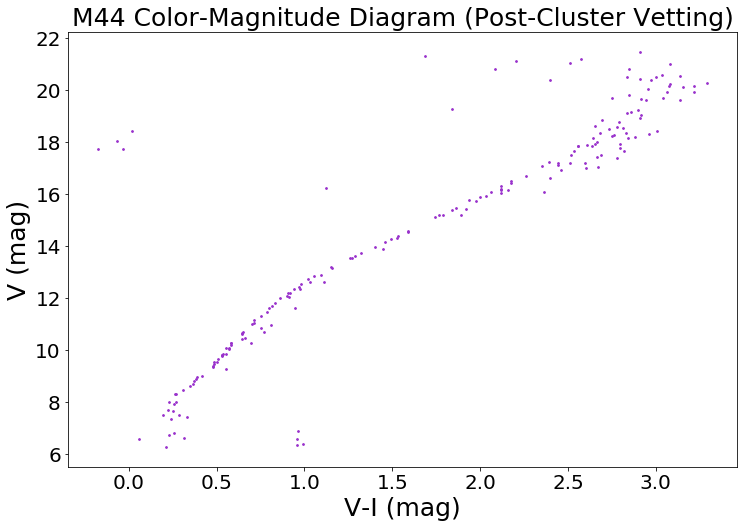

In [211]:
plt.scatter(V_I, V, s=3, c='darkorchid')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('V-I (mag)', fontsize=25)
plt.ylabel('V (mag)', fontsize=25)
plt.title('M44 Color-Magnitude Diagram (Post-Cluster Vetting)', fontsize=25)

plt.savefig('M44/M44_Plot4.png', dpi=150)

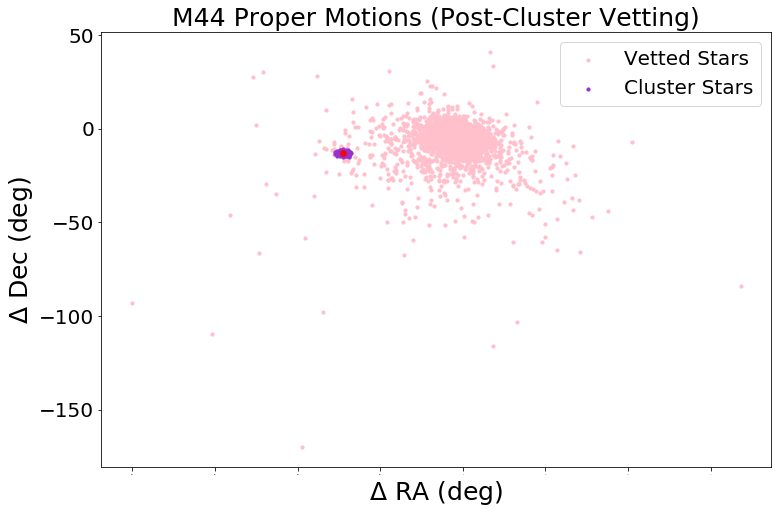

In [212]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(pmra0, pmdec0, s=10, c='pink', label='Vetted Stars')
ax.scatter(pmra, pmdec, s=10, color='darkorchid', label='Cluster Stars')
ax.scatter(ra_center, dec_center, c='r', s=30)

#plt.xlim(-12, -10)
#plt.ylim(-4, -2)
plt.xticks(fontsize=0)
plt.yticks(fontsize=20)
plt.xlabel('$\Delta$ RA (deg)', fontsize=25)
plt.ylabel('$\Delta$ Dec (deg)', fontsize=25)
plt.title('M44 Proper Motions (Post-Cluster Vetting)', fontsize=25)
plt.legend(fontsize=20);

plt.savefig('M44/M44_Plot5.png', dpi=150)

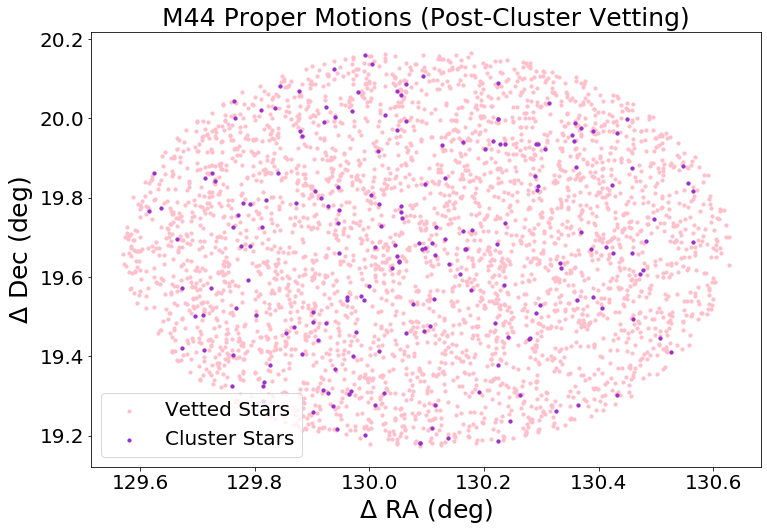

In [213]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(ra0, dec0, s=10, c='pink', label='Vetted Stars')
ax.scatter(M44df['ra'], M44df['dec'], s=10, color='darkorchid', label='Cluster Stars')

#plt.xlim(-12, -10)
#plt.ylim(-4, -2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$\Delta$ RA (deg)', fontsize=25)
plt.ylabel('$\Delta$ Dec (deg)', fontsize=25)
plt.title('M44 Proper Motions (Post-Cluster Vetting)', fontsize=25)
plt.legend(fontsize=20);

plt.savefig('M44/M44_Plot6.png', dpi=150)

# Step 7 - Parallax Histogram

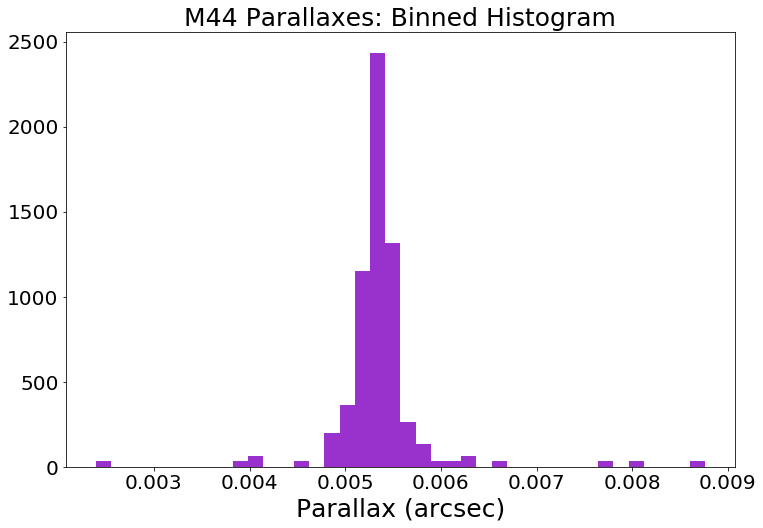

In [214]:
plt.hist(M44df['parallax_arcsec'], bins=40, density=True, color='darkorchid');

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Parallax (arcsec)', fontsize=25)
plt.title('M44 Parallaxes: Binned Histogram', fontsize=25)

plt.savefig('M44/M44_Plot7.png', dpi=150)

In [215]:
parallax_arcs = np.median(M44df['parallax_arcsec'])
parallax_err_arcs = np.std(M44df['parallax_arcsec'])/np.sqrt(len(M44df))

print('Mean cluster parallax (arcs): ', parallax_arcs)
print('Sigma of cluster parallax (arcs): ', parallax_err_arcs)

Mean cluster parallax (arcs):  0.005358150561277695
Sigma of cluster parallax (arcs):  3.692152072776459e-05


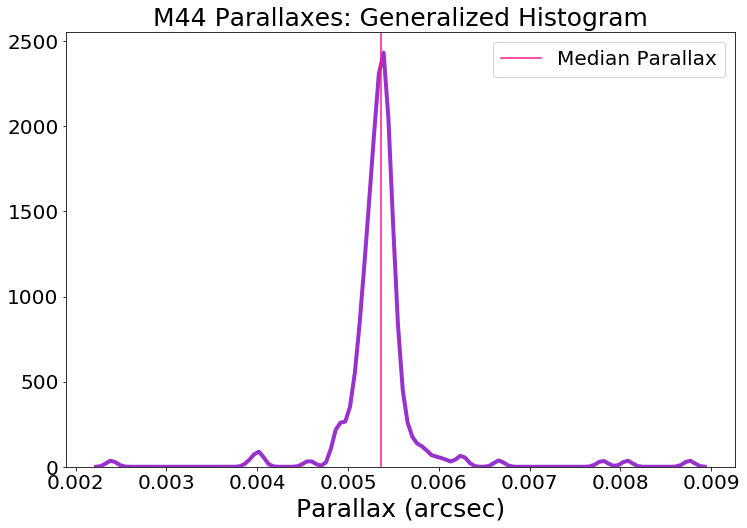

In [216]:
sns.distplot(M44df['parallax_arcsec'], hist=False, kde=True, 
             bins=25, color = 'darkorchid',
             kde_kws={'linewidth': 4},)

plt.axvline(np.median(M44df['parallax_arcsec']), color='deeppink', label='Median Parallax')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Parallax (arcsec)', fontsize=25)
plt.title('M44 Parallaxes: Generalized Histogram', fontsize=25)
plt.legend(fontsize=20)

plt.savefig('M44/M44_Plot8.png', dpi=150)

### Define Av

In [217]:
Av = 0.082

# Step 9: Stellar Parallax

Get Stellar Distances, Absolute V mag, Absolute I mag, and Absolute V-I for all stars in cluster.

In [218]:
M44_dists = np.zeros(len(M44df))
M44_absV = np.zeros(len(M44df))
M44_absI = np.zeros(len(M44df))
M44_absVI = np.zeros(len(M44df))

M44_disterrs = np.zeros(len(M44df))
M44_absVerrs = np.zeros(len(M44df))
M44_absIerrs = np.zeros(len(M44df))
M44_absVIerrs = np.zeros(len(M44df))

V = np.array(V)
I = np.array(I)

i = 0

for index, row in M44df.iterrows():
    M44_dists[i] = parallax_dist(row['parallax_arcsec'])
    M44_disterrs[i] = parallax_dist_errprop(row['parallax_arcsec'], row['parallax_err_arcsec'])
    
    M44_absV[i] = dist_mag(M44_dists[i], V[i], Av)
    M44_absI[i] = dist_mag(M44_dists[i], I[i], Av)
    M44_absVI[i] = M44_absV[i]-M44_absI[i]
    
    
    i+=1

In [221]:
# Get (V-I)_0
V_I_naught = V_I0(Av, V_I)



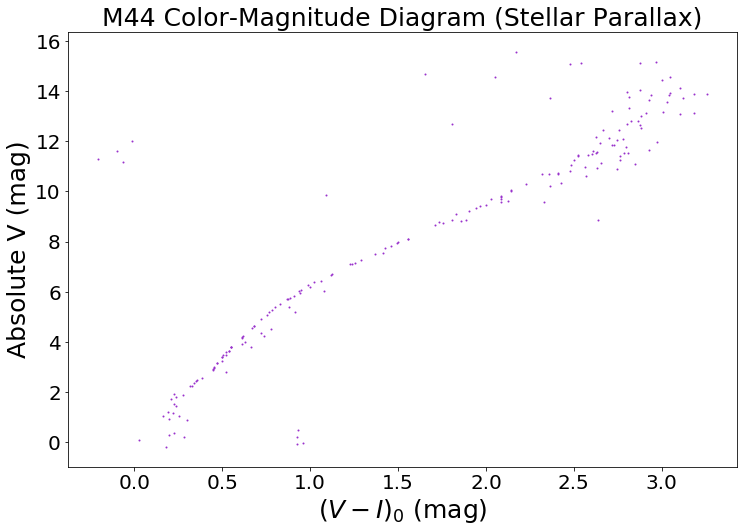

In [222]:
plt.scatter(V_I_naught, M44_absV, s=1, color='darkorchid')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$(V-I)_0$ (mag)', fontsize=25)
plt.ylabel('Absolute V (mag)', fontsize=25)
plt.title('M44 Color-Magnitude Diagram (Stellar Parallax)', fontsize=25)

plt.savefig('M44/M44_Plot9.png', dpi=150)


# Step 10: Cluster Parallax

In [223]:
cluster_dist = 1/parallax_arcs
cluster_dist_err = cluster_dist * (parallax_err_arcs/parallax_arcs)

In [224]:
print('Distance to M44: ', cluster_dist, ' parsecs')
print('Distance to M44 Error: ', cluster_dist_err, ' parsecs')

Distance to M44:  186.631560379584  parsecs
Distance to M44 Error:  1.2860260170379965  parsecs


In [225]:
M44_absV_c = np.zeros(len(M44df))
M44_absI_c = np.zeros(len(M44df))
M44_absVI_c = np.zeros(len(M44df))

M44_absVerrs_c = np.zeros(len(M44df))
M44_absIerrs_c = np.zeros(len(M44df))
M44_absVIerrs_c = np.zeros(len(M44df))

i = 0

for index, row in M44df.iterrows():
    M44_absV_c[i] = dist_mag(cluster_dist, V[i], Av)
    M44_absI_c[i] = dist_mag(cluster_dist, I[i], Av)
    M44_absVI_c[i] = M44_absV_c[i]-M44_absI_c[i]
    
    i+=1

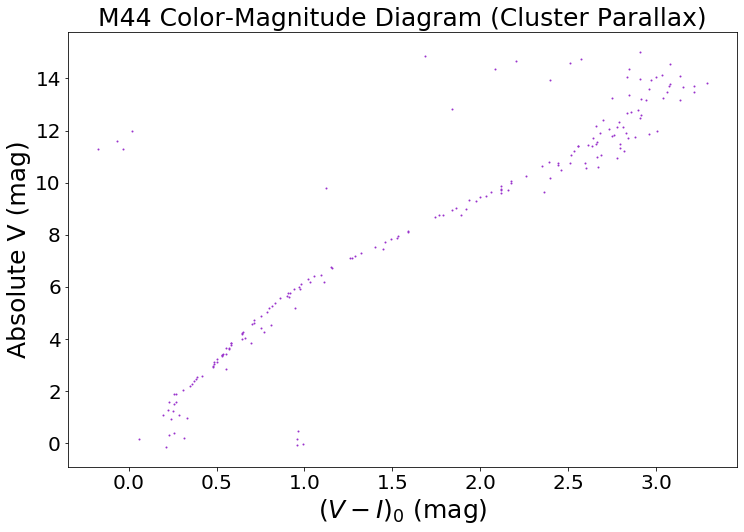

In [226]:
plt.scatter(M44_absVI_c, M44_absV_c, s=1, color='darkorchid')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$(V-I)_0$ (mag)', fontsize=25)
plt.ylabel('Absolute V (mag)', fontsize=25)
plt.title('M44 Color-Magnitude Diagram (Cluster Parallax)', fontsize=25)

plt.savefig('M44/M44_Plot10.png', dpi=150)

# Step 12: Luminosity Function

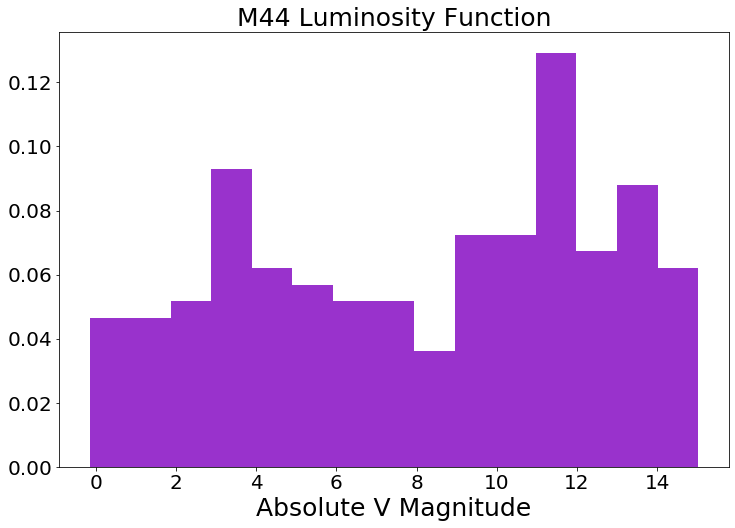

In [227]:
plt.hist(M44_absV_c, bins=15, density=1, color='darkorchid');
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Absolute V Magnitude', fontsize=25)
plt.title('M44 Luminosity Function', fontsize=25)

plt.savefig('M44/M44_Plot11.png', dpi=150)

np.savetxt("M44lumfunc.csv", M44_absV_c, delimiter=',')

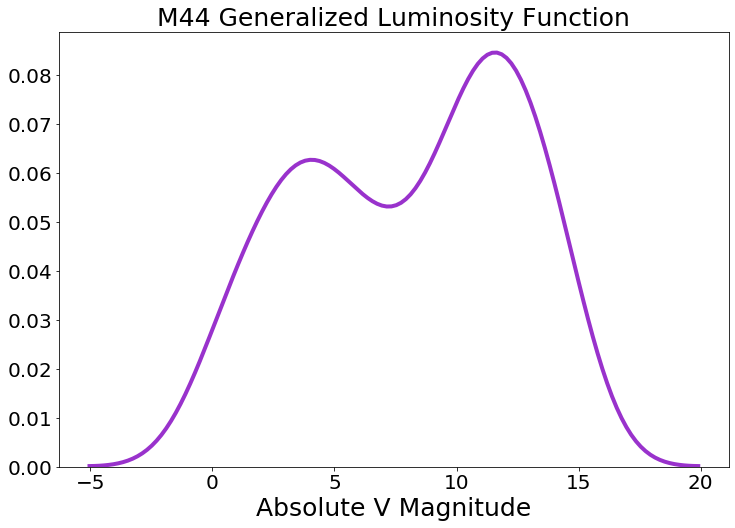

In [228]:
sns.distplot(M44_absV_c, hist=False, kde=True, 
             bins=25, color = 'darkorchid',
             kde_kws={'linewidth': 4},)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Absolute V Magnitude', fontsize=25)
plt.title('M44 Generalized Luminosity Function', fontsize=25)

plt.savefig('M44/M44_Plot12.png', dpi=150)

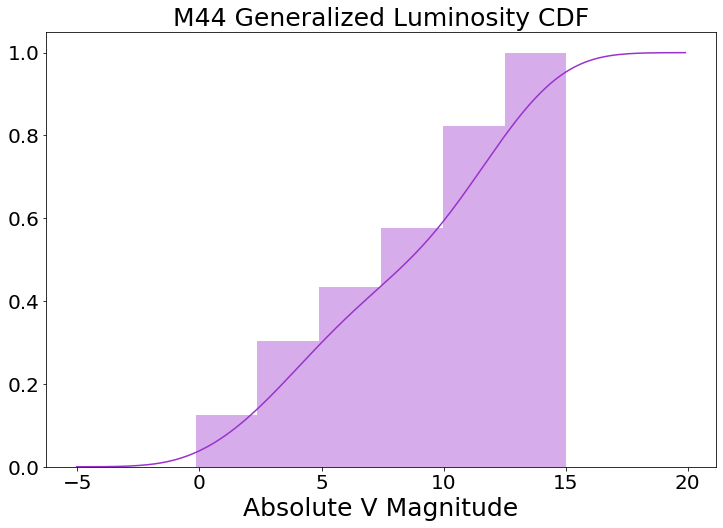

In [229]:
kwargs = {'cumulative': True}
sns.distplot(M44_absV_c, hist_kws=kwargs, kde_kws=kwargs, color = 'darkorchid')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Absolute V Magnitude', fontsize=25)
plt.title('M44 Generalized Luminosity CDF', fontsize=25)

plt.savefig('M44/M44_Plot13.png', dpi=150)